# Τρίτη Άσκηση νευρωνικών

Ομάδα 49 <br>
Γιάννης Βουλγαρίδης, 03116151 <br>
Μαρία-Ιωάννα Σωτηρίου, 03116090 <br>
Ευάγγελος Ζάχος, 03116015 <br> 

<br> Όλη η εργασία υλοποιήθηκε στο Google Colab και για επιτάχυνση υλικού χρησιμοποιήθηκε η GPU που παρέχει το Colab.

# Βοηθητικές Συναρτήσεις και Αρχικοποιήσεις

(50000, 32, 32, 3)
OUR CLASSES
[' bear', ' beetle', ' bottle', ' bowl', ' bridge', ' castle', ' crab', ' fox', ' house', ' lion', ' lizard', ' man', ' mushroom', ' pear', ' porcupine', ' snail', ' table', ' television', ' wardrobe', ' woman']
DATASET ELEMENT SIZE:
(32, 32, 3)
1500
Train: X=(8500, 32, 32, 3), y=(8500, 1)
Validation: X=(1500, 32, 32, 3), y=(1500, 1)
Test: X=(2000, 32, 32, 3), y=(2000, 1)


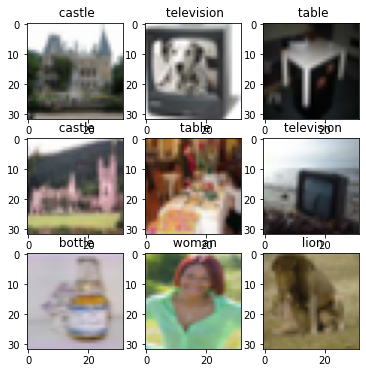

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
'''
helpers
'''
# helper functions

# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

# select a url for a unique subset of CIFAR-100 with 20, 40, 60, or 80 classes
def select_classes_number(classes_number = 20):
  cifar100_20_classes_url = "https://pastebin.com/raw/nzE1n98V"
  cifar100_40_classes_url = "https://pastebin.com/raw/zGX4mCNP"
  cifar100_60_classes_url = "https://pastebin.com/raw/nsDTd3Qn"
  cifar100_80_classes_url = "https://pastebin.com/raw/SNbXz700"
  if classes_number == 20:
    return cifar100_20_classes_url
  elif classes_number == 40:
    return cifar100_40_classes_url
  elif classes_number == 60:
    return cifar100_60_classes_url
  elif classes_number == 80:
    return cifar100_80_classes_url
  else:
    return -1

# load the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')
print(x_train_all.shape)
# REPLACE WITH YOUR TEAM NUMBER
team_seed = 49

# select the number of classes
cifar100_classes_url = select_classes_number()
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

# print our classes
print('OUR CLASSES')
print(our_classes)

CLASSES_NUM=len(our_classes)
print('DATASET ELEMENT SIZE:')
print(x_train_ds[1].shape)
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

print(len(x_val))

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

# we user prefetch https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch 
# see also AUTOTUNE
# the dataset is now "infinite"

BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

def _input_fn(x,y, BATCH_SIZE):
  ds = tf.data.Dataset.from_tensor_slices((x,y))
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object

# steps_per_epoch and validation_steps for training and validation: https://www.tensorflow.org/guide/keras/train_and_evaluate

def train_model(model, epochs = 200, steps_per_epoch = 50, validation_steps = 10):
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0.001,
                                                  patience=20,
                                                  restore_best_weights=True)
  history = model.fit(train_ds, 
                      epochs=epochs, 
                      steps_per_epoch=steps_per_epoch, 
                      validation_data=validation_ds, 
                      validation_steps=validation_steps,
                      callbacks=[early_stop])
  return history


# plot diagnostic learning curves
def summarize_diagnostics(history):
	plt.figure(figsize=(8, 8))
	plt.suptitle('Training Curves')
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.legend(loc='upper right')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.legend(loc='lower right')
	return plt

# print test set evaluation metrics
def model_evaluation(model, evaluation_steps):
	print('\n\nTest set evaluation metrics')
	loss0,accuracy0 = model.evaluate(test_ds, steps = evaluation_steps)
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history, evaluation_steps = 10):
  plt = summarize_diagnostics(history)
  plt.show()
  #print("RESULTS IN test_ds: ")
  model_evaluation(model, evaluation_steps)

# Μοντέλα from scratch - Μέρος 1

## Πρώτο CNN from scratch

Στα επόμενα κελιά θα προσπαθήσουμε να φτιάξουμε ένα ικανοποιητικό μοντέλο from scratch, ξεκινώντας από το απλό συνελικτικό μοντέλο της εκφώνησης και προσθέτοντας επίπεδα ανάλογα με τις ανάγκες. 

In [ ]:
def init_fs_model_1(summary=True):
  model = models.Sequential()
 
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
 
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
 
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
 
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

init_fs_model_1()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [ ]:
model = init_fs_model_1()
%time history =  train_model(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

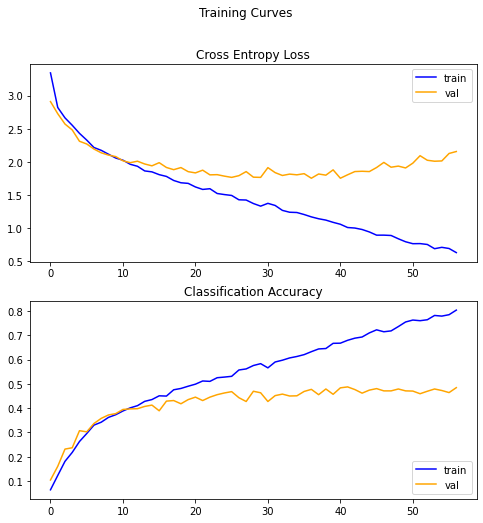



Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 1.8157 - accuracy: 0.4742
loss: 1.82
accuracy: 0.47


In [ ]:
model_report(model, history, 10)

## Δεύτερο CNN from scratch

Στο επόμενο μοντέλο θα προσθέσουμε επιπλέον επίπεδα Conv2d-MaxPooling για να δούμε αν θα βελτιωθεί η απόδοση, αν θα υποβαθμιστεί ή αν έχουμε φτάσει σε κορεσμό. 

In [ ]:
def init_fs_model_2(summary=True):
  model = models.Sequential()
 
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
 
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
 
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  
  model.add(layers.Flatten())
 
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

init_fs_model_2()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 2, 64)         

In [ ]:
model = init_fs_model_2()
%time history =  train_model(model)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 2, 2, 64)         

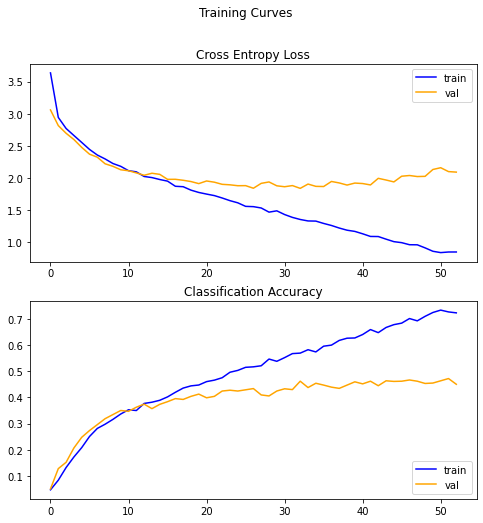



Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 2.0014 - accuracy: 0.4125
loss: 2.00
accuracy: 0.41


In [ ]:
model_report(model, history, 10)

## Τρίτο CNN from scratch

Στο προηγούμενο μοντέλο (2) η τιμή της μετρικής ήταν πιο χαμηλή από ότι η τιμή της στο μοντέλο 1. Η προσθήκη ενός ακόμα Conv2D-MaxPool δεν βοήθησε, και ίσως αυτό οφείλεται σε overfitting. Παραητρούμε ότι το μοντέλο πετυχαίνει υψηλότερες τιμές accuracy στο training και χαμηλότερες στο validation, στο επόμενο μοντέλο λοιπόν θα χρησιμοποιήσουμε κάποια τεχνική για μείωση overfitting. Αρχικά θα χρησιμοποιήσουμε το batch normalization.

In [ ]:
def init_fs_model_3(summary=True):
  model = models.Sequential()
 
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
 
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  
  model.add(layers.Flatten())
 
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

init_fs_model_3()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 2, 2, 64)         

In [ ]:
model = init_fs_model_3()
%time history =  train_model(model)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 2, 2, 64)         

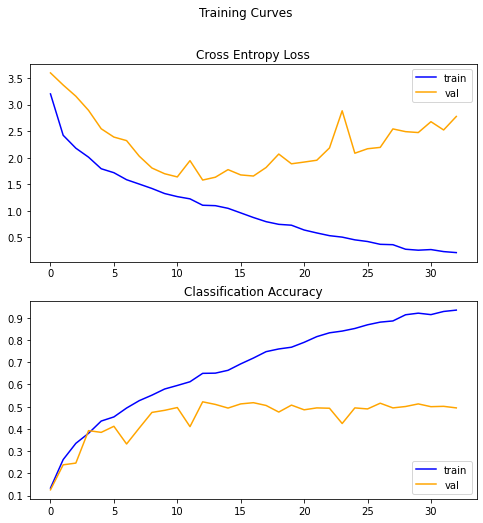



Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 1.6401 - accuracy: 0.4867
loss: 1.64
accuracy: 0.49


In [ ]:
model_report(model, history, 10)

Παρατηρούμε ότι το τελευταίο μοντέλο έχει την καλύτερη τιμή για την μετρική. Στην συνέχεια θα προσπαθήσουμε να προσθέσουμε και ένα dropout layer.

## Τέταρτο CNN from scratch

In [ ]:
def init_fs_model_4(summary=True):
  model = models.Sequential()
 
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
 
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  
  model.add(layers.Dropout(rate = 0.4))
  model.add(layers.Flatten())
  
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

init_fs_model_4()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 2, 2, 64)         

In [ ]:
model = init_fs_model_4()
%time history =  train_model(model)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 2, 2, 64)         

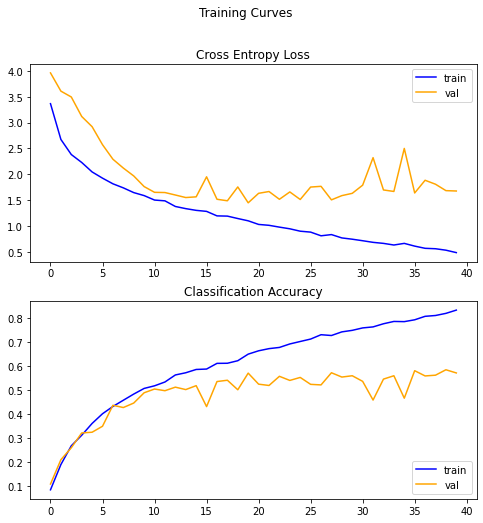



Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 1.4756 - accuracy: 0.5453
loss: 1.48
accuracy: 0.55


In [ ]:
model_report(model, history, 10)

## Πέμπτο CNN μοντέλο from scratch

Στο επόμενο μοντέλο, προσθέτουμε ένα επίπεδο Batch Nοrmalization μετά από κάθε conv2d-MaxPool layer. Με αυτό τον τρόπο μειώνουμε το overfitting σε όλα τα ενδιάμεσα στάδια από την είσοδο έως την έξοδο. 

In [ ]:
def init_fs_model_5(summary=True):
  model = models.Sequential()
 
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  
  model.add(layers.Flatten())
  
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

init_fs_model_5()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 4, 4, 64)         

In [ ]:
model = init_fs_model_5()
%time history =  train_model(model)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 4, 4, 64)         

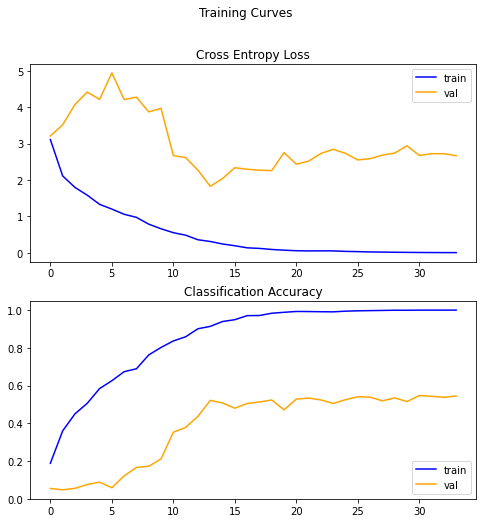



Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 2.0171 - accuracy: 0.4805
loss: 2.02
accuracy: 0.48


In [ ]:
model_report(model, history, 10)

# Pretrained Μοντέλα - Μέρος 2 

## VGG16 model

In [ ]:
def init_VGG16_model(summary):
  vgg_model=tf.keras.applications.VGG16(input_shape=(32,32,3), include_top=False, weights='imagenet')
  VGG16_MODEL=vgg_model.layers[0](vgg_model)
  # unfreeze conv layers
  VGG16_MODEL.trainable=True
  dropout_layer = tf.keras.layers.Dropout(rate = 0.2)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([VGG16_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
model = init_VGG16_model(summary=True)
%time history=train_model(model)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)               51300     
Total params: 14,765,988
Trainable params: 14,765,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
50/50 [==============================] - 5s 62ms/step - loss: 3.8224 - accuracy: 0.1050 - val_loss: 1.6928 - val_accuracy: 0.4891
Epoch 2/200
50/50 [==============================] - 3s 60ms/step - loss: 1.7953 - accuracy: 0.44

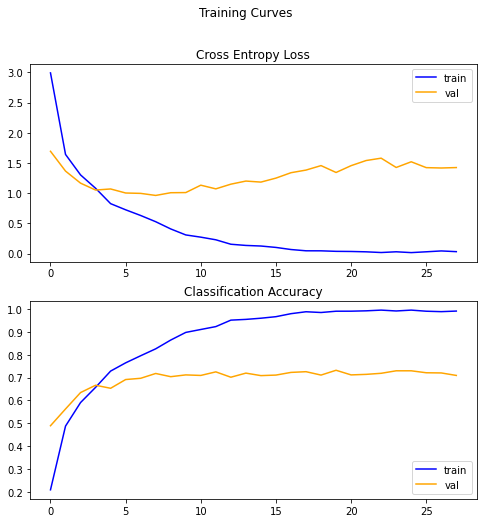



Test set evaluation metrics
10/10 [==============================] - 0s 16ms/step - loss: 0.9071 - accuracy: 0.7391
loss: 0.91
accuracy: 0.74


In [ ]:
model_report(model, history, 10)

## VGG19 model

In [ ]:
def init_VGG19_model(summary):
  vgg_model=tf.keras.applications.VGG19(input_shape=(32,32,3), include_top=False, weights='imagenet')
  VGG19_MODEL=vgg_model.layers[0](vgg_model)
  # unfreeze conv layers
  VGG19_MODEL.trainable=True
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([VGG19_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
model = init_VGG19_model(summary=True)
%time history=train_model(model)

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               51300     
Total params: 20,075,684
Trainable params: 20,075,684
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
50/50 [==============================] - 5s 77ms/step - loss: 4.1674 - accuracy: 0.0639 - val_loss: 2.1389 - val_accuracy: 0.3984
Epoch 2/200
50/50 [=============

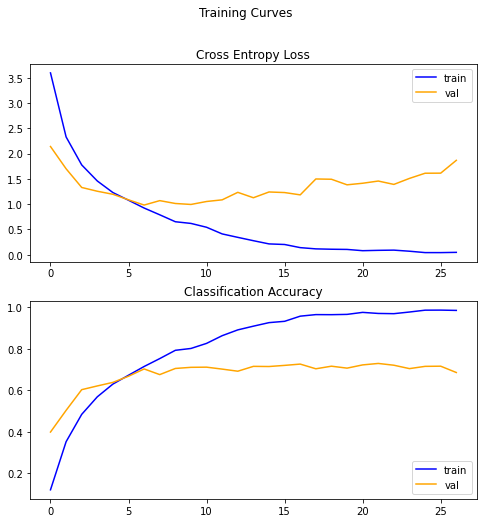



Test set evaluation metrics
10/10 [==============================] - 0s 19ms/step - loss: 1.0477 - accuracy: 0.6875
loss: 1.05
accuracy: 0.69


In [ ]:
model_report(model, history, 10)

## RESNET model

In [ ]:
def init_resnet_model(summary):
  vgg_model=tf.keras.applications.ResNet101(input_shape=(32,32,3), include_top=False, weights='imagenet')
  RESNET_MODEL=vgg_model.layers[0](vgg_model)
  # unfreeze conv layers
  RESNET_MODEL.trainable=True
  dropout_layer = tf.keras.layers.Dropout(rate = 0.2)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([RESNET_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
model = init_resnet_model(summary=True)
%time history =  train_model(model)

171450368/171446536 [==============================] - 2s 0us/step
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 1, 1, 2048)        42658176  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               204900    
Total params: 42,863,076
Trainable params: 42,757,732
Non-trainable params: 105,344
_________________________________________________________________
Epoch 1/200
50/50 [==============================] - 18s 150ms/step - loss: 5.8189 - accuracy: 0.0373 - val_loss: 25.9315 - val_accuracy: 0.0555
Epoch 2/200
50/50 [==

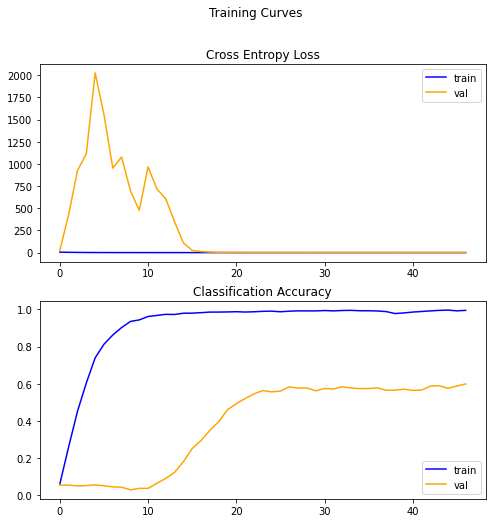



Test set evaluation metrics
10/10 [==============================] - 0s 32ms/step - loss: 2.1468 - accuracy: 0.5219
loss: 2.15
accuracy: 0.52


In [ ]:
model_report(model, history, 10)

# Βελτιστοποίηση - Μέρος 3

Εφόσον έγινε μια πρωταρχική ανάλυση του προβλήματος στο επόμενο κεφάλαιο προσπαθούμε να βελτιστοποιήσουμε την διαδικασία ως προς όποια παράμετρο μπορούμε. Θα δούμε τρόπους να διαχειριστούμε καλύτερα τα δεδομένα όσον αφορά την αποθήκευση τους, τρόπους για να κάνουμε καλύτερο trainng κλπ. Από την αρχή της άσκησης σιωπηρά χρησιμοποιήσαμε μια τακτική βελτιστοποίησης. Στην συνάρτηση train_model() από την οποία καλούμε την fit() για όλα τα μοντέλα έχουμε προσθέσει και την δυνατότητα early stop, με patience 20 και min_delta=0.01. Αυτό σημαίνει ότι αν για 20 συνεχόμενες εποχές η βελτίωση στο val_loss είναι μικρότερη από το 0.01 η διαδικασία του fit() θα σταματάει και θα θεωρείται ότι ολοκληρώθηκε επιτυχώς. Αν η συνθήκη αυτή δεν εκπληρωθεί το μοντέλο θα τρέξει για 200 εποχές, όπως ορίσαμε σαν default (και max). Με αυτό τον τρόπο επιτρέπουμε στα μοντέλα με αργή μάθηση να φτάσουν σε καλό επίπεδο και από την άλλη δεν επιτρέπουμε σε ένα μοντέλο που "μαθαίνει γρήγορα" να ξοδεύει χρόνο κάνοντας fit() ενώ στην πραγματικότητα δεν βελτιώνεται καθόλου.   

## Data Augmentation - Κατασκευή μεγαλύτερου πλήθους δεδομένων 

Στα επόμενο κελί κατασκευάζεται ένα μοντέλο keras το οποίο έχει ένα layer μόνο στο οποίο διπλασιάζεται ο όγκος των δεδεομένων που έχουμε στην διάθεση μας, περιστρέφοντας κάθε εικόνα κατά 0.1. Με τον τρόπο αυτό το νευρωνικό βλέπει πολλές φορές την ίδια εικόνα αλλά ελαφρώς διαφορετική με αποτέλεσμα να την περνά για διαφορετική. Με αυτό τον τρόπο αποφεύγεται το overfit που προκύπτει όταν υπάρχουν πολλές κλάσεις αλλά λίγα στιγμυότυπα ανά κλάση και το νευρωνικό στην ουσία μαθαίνει να ταξινομεί αυτά τα λίγα δειγματα.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.1),
])

In [ ]:
model = models.Sequential([
                                data_augmentation,
                                init_VGG16_model(summary=True)
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005),
                   loss=tf.keras.losses.sparse_categorical_crossentropy,
                   metrics=["accuracy"])

%time history =  train_model(model)


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 100)               51300     
Total params: 14,765,988
Trainable params: 14,765,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
50/50 [==============================] - 5s 70ms/step - loss: 3.5059 - accuracy: 0.1274 - val_loss: 1.9534 - val_accuracy: 0.4031
Epoch 2/200
50/50 [==============================] - 3s 62ms/step - loss: 2.1151 - accuracy: 0.35

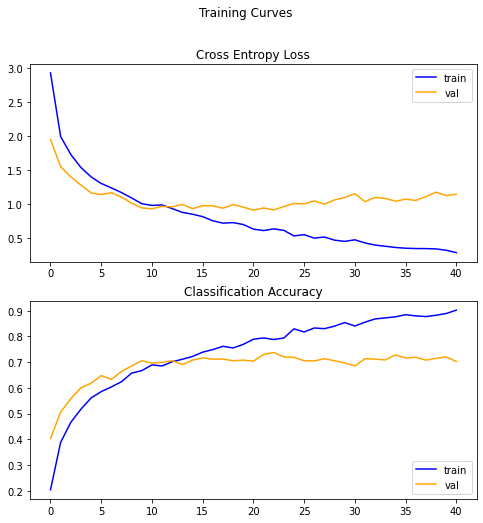



Test set evaluation metrics
10/10 [==============================] - 0s 16ms/step - loss: 1.0326 - accuracy: 0.6938
loss: 1.03
accuracy: 0.69


In [ ]:
model_report(model, history, 10)

In [ ]:
model = models.Sequential([
                                data_augmentation,
                                init_fs_model_5()
])          
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005),
                   loss=tf.keras.losses.sparse_categorical_crossentropy,
                   metrics=["accuracy"])

%time history =  train_model(model)


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 6, 6, 64)          256       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 4, 4, 64)        

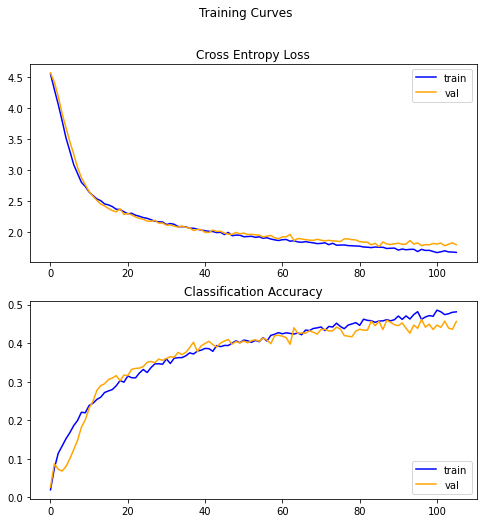



Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 1.8843 - accuracy: 0.4078
loss: 1.88
accuracy: 0.41


In [ ]:
model_report(model, history, 10)

Αυτό που παρατηρούμε από την εφαρμογή του data augmentation στην περίπτωση του VGG16 δικτύου είναι ότι  το accuracy βελτιώθηκε ελάχιστα (~ 1%) και το loss έμεινε σταθερό σε σχέση με την πρώτη εφαρμογή του VGG16. Από την άλλη, για το model_5 το accuracy έπεσε κατά 0.01 και το loss επίσης μειώθηκε και μάλιστα αισθητά. Αυτό που παρατηρείται επίσης από τις γραφικές που προέκυψαν από το μοντέλο data augmentation + fs_model_5 είναι ότι οι γραφικές του training και του validation ήρθαν "πιο κοντά" και αναφορικά με το accuracy και αναφορικά με το loss. Αυτό είναι μια ένδειξη ότι το data augmentaion βοηθάει στο overfitting.

## Image Resize

Στο επόμενο κελί κώδικα υλοποιείται η μετατροπή των δεδομένων από εικόνες 32x32 pixels σε εικόνες NxN. Αυτό θα μας επιτρέψει να χρησιμοποιήσουμε επιπλέον μοντέλα transfer learning τα οποία δεν μπορέσαμε να χρησιμοποιήσουμε παραπάνω γιατί οι διαστάσεις 32x32 pixels δεν ήταν αποδεκτές.

In [ ]:
IMG_SIZE = 72
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
])

In [ ]:
def init_xception_model(summary=True):
  vgg_model=tf.keras.applications.Xception(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
  RESNET_MODEL=vgg_model.layers[0](vgg_model)
  # unfreeze conv layers
  RESNET_MODEL.trainable=True
  dropout_layer = tf.keras.layers.Dropout(rate = 0.2)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([RESNET_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
model = models.Sequential([
                           resize_and_rescale,
                           init_xception_model()
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005),
                   loss=tf.keras.losses.sparse_categorical_crossentropy,
                   metrics=["accuracy"])

%time history = train_model(model)

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)               204900    
Total params: 21,066,380
Trainable params: 21,011,852
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/200
50/50 [==============================] - 21s 309ms/step - loss: 4.3542 - accuracy: 0.0902 - val_loss: 3.0435 - val_accuracy: 0.3930
Epoch 2/200
50/50 [======

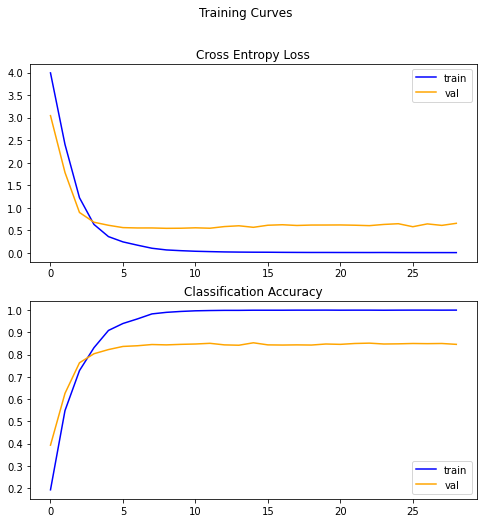



Test set evaluation metrics
10/10 [==============================] - 1s 65ms/step - loss: 0.5725 - accuracy: 0.8445
loss: 0.57
accuracy: 0.84


In [ ]:
model_report(model, history, 10)

# Συμπεράσματα - Μέρος 4

Στο παρακάτω διάγραμμα φαίνονται συνοπτικά τα κυρίοτερα στοιχεία για κάθε μοντέλο το οποίο κατασκευάσαμε, είτε εκ θεμελίων (from scratch) είναι με tranfer learning. Εξετάζοντας το διάγραμμα, η πρώτη παρατήρηση είναι τα tranfer learning μοντέλα (πλήν του RESNET) πετυχαίνουν πολύ καλύτερα αποτελέσματα, αλλά προφανώς χρειάζονται περισσότερο χρόνο και περισσότερο χώρο στη μνήμη εφόσον έχουν πιο πολλές παραμέτρους. Σε όλα τα tranfer learning μοντέλα βάλαμε ακριβώς τα ίδια top επίπεδα, για να εξετάσουμε πιο αντικειμενικά. 

<br> Τα μοντέλα στα οποία χρησιμοποιήθηκε data augmentation δεν συμπεριλήφθηκαν στον πίνακα διότι η απόδοση δεν είχε μεγάλη διαφορά (~0.01 καλύτερη).

## Πίνακας για 20 ομάδες


|     model       | Accuracy | Loss  | Training Time | Epochs | Trainable Parameters |
|------------|----------|-------|---------------|--------|----------------------|
| fs_model_1 | 0.49     | 1.73  | 31.6 s        | 52     | 128,420              |
| fs_model_2 | 0.44     | 1.88  | 31 s          | 50     | 116,196              |
| fs_model_3 | 0.50     | 1.58  | 20 s          | 31     | 116,260              |
| fs_model_4 | 0.54     | 1.51  | 23.4 s        | 36     | 116,260              |
| fs_model_5 | 0.49     | 1.79  | 21 s          | 32     | 116,516              |
| VGG16      | 0.71     | 0.94  | 1 min 13 s    | 28     | 14,765,988           |
| VGG19      | 0.73     | 1.06  | 1min 39s      | 32     | 20,075,684           |
| RESNET     | 0.54     | 2.08  | 4min 15s      | 45     | 42,757,732           |
| Xception   | 0.84     | 0.55  | 6min 10s      | 28     | 21,011,852           |


<br>
Επικεντρώνοντας τώρα στα μοντέλα που κατασκευάσαμε εκ θεμελίων, μπορούμε να πούμε με σιγουριά ότι τα πολλά επίπεδα δεν εγγυόνται καλύτερες επιδόσεις. Είδαμε μοντέλα με λιγότερα κρυφά επίπεδα να σημειώνουν καλύτερη τιμή για την μετρική από άλλα μοντέλα με πιο πολλά επίπεδα (π.χ. το fs_model_1 ήταν καλύτερο από το fs_model_2). Από την άλλη, πολύ σημαντική ήταν η επίδραση των επιπέδων BatchNormalization και Dropout. Το dropout layer αποτελεί τρόπο αντιμετώπισης του overfitting που είναι πολύ πιθανό να εμφανιστεί όσο το μοντέλο γίνεται πιο σύνθετο. Η δράση του είναι πολύ απλή, απλά κάνει αυθαίρετα μηδέν ένα ποσοστό των βαρών σε κάθε εποχή της εκπαίδευσης. Από την άλλη, το batch Normalization προσπαθεί να έχει ως έξοδο την είσοδο του αλλά κανονικοποιημένη, δηλάδή κάθε feature να έχει περίπου μέση τιμή 0 και τυπική απόκλιση 1. Και το επίπεδο αυτό βοηθάει στην αντιμετώπιση του overfitting, αφού δεν αφήνει τα βάρη να γίνουν πολύ μεγάλα. 
